In [7]:
%run functions.py
%run plot_functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import product

from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

## Load settings

In [8]:
pd.set_option('display.max_colwidth',-1)

k=10 # Define k for crossvalidation
seed = 42 # Seed to use

score_function = f_regression # Score function for Feature selection
feature_tot = 0 # Total selected features -> Start at 0 before PCA
scoring='neg_mean_squared_error' # Scoring method for GridsearchCV

np.random.seed(seed) # Define the random seed


# Task 2 - Regression 

## Load dataset

In [9]:
filename = "datasets/ChemTrainNew.mat"

mat = loadmat(filename)
input_train = mat['XtrainDS']

target_train = mat['YtrainDS'].reshape(len(input_train))
input_test = mat['XtestDS']

## Data info

In [10]:
# The shape should look like (401,133) where 401 is the number of features and 133 is each row
print("Length of",len(input_train))
print("X.shape:", input_train.shape, "y.shape:", target_train.shape)    
print("Contains Nan:",np.isnan(input_train).any(), np.isnan(target_train).any())
print("Contains +inf:",np.isinf(input_train).any(),np.isinf(target_train).any())
print("Contains -inf:",np.isneginf(input_train).any(),np.isneginf(target_train).any())
#pd.DataFrame(input_train).describe()

Length of 4466
X.shape: (4466, 65) y.shape: (4466,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False


## Preprocess
Normalize the dataset

In [11]:
input_train_copy = deepcopy(input_train)

# In case one-hot
if len(target_train.T) == 3:
    for index,item in enumerate(target_train):
        item[0] = int("".join(str(x) for x in item), 2)
    

# Normalizing data
scaler = StandardScaler()
scaler.fit(input_train,y=target_train)

input_train_copy_normalized = deepcopy(input_train_copy)

input_train = scaler.transform(input_train)
input_test = scaler.transform(input_test)

## Feature reduction
Reduce dimensionality by PCA transform

In [12]:
pca = PCA(n_components = .95, svd_solver = 'full')
pca.fit(input_train,y=input_train)

pca_input = pca.transform(input_train)

feature_tot = len(pca_input[0])
print("original shape:   ", input_train_copy.shape)
print("transformed shape:", pca_input.shape)
print("Explained variance:",pca.explained_variance_ratio_)

original shape:    (4466, 65)
transformed shape: (4466, 27)
Explained variance: [0.35039688 0.11184843 0.08050837 0.06509726 0.04016244 0.03188509
 0.02768326 0.02504262 0.01980678 0.01818787 0.01670203 0.01611922
 0.01469088 0.01361669 0.01296212 0.01277008 0.01182579 0.01098518
 0.01063263 0.00964813 0.00948931 0.00886604 0.00871726 0.00745555
 0.00668993 0.0063179  0.00532895]


# Plot PCA

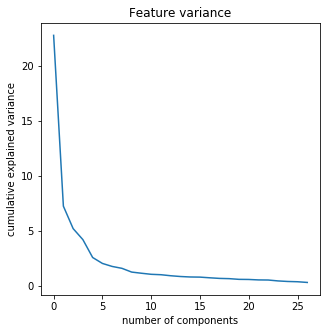

In [13]:
from math import ceil

cntItems = 1
rowItems = 1
fig, ax = plt.subplots(cntItems,rowItems,figsize=(5,5))

if cntItems == 1: axlist = range(rowItems)
else: axlist = list(product(range(cntItems),range(rowItems)))

# Plot feature variance
plt.title("Feature variance")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
feature_variance = np.var(pca_input, 0)
plt.plot(feature_variance)

plt.show()



## Plot top 10 histogram over reduced features

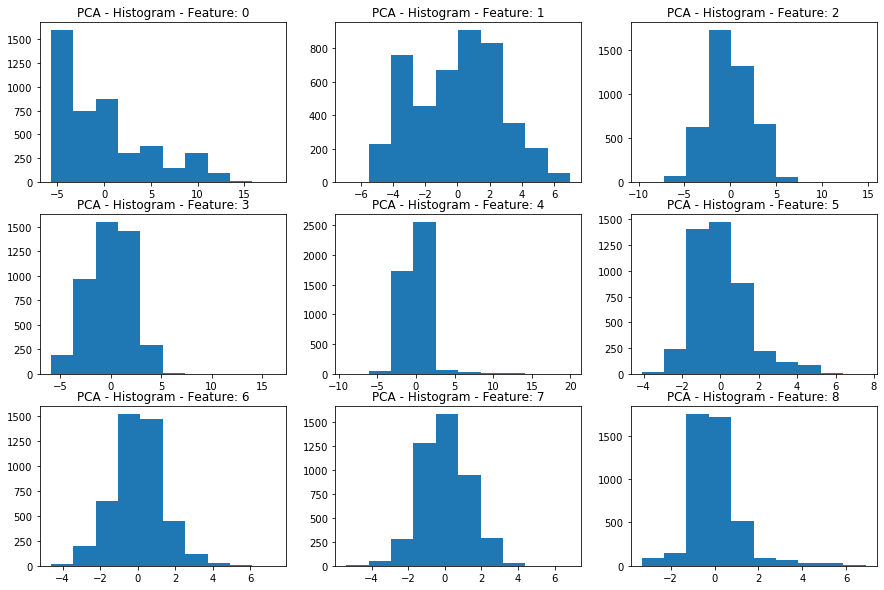

In [14]:
from math import ceil
startpos = 1
cntPlots = length if (length := feature_tot) <= 9 else 9
rowItems = 3
cntItems = ceil(cntPlots/rowItems)

fig, ax = plt.subplots(cntItems,rowItems,figsize=(15,10))
if cntItems == 0: axlist = range(rowItems)
else: axlist = list(product(range(cntItems),range(rowItems)))


for index in range(0,(cntPlots)):
    ax[axlist[index]].set_title("PCA - Histogram - Feature: " + str(index))
    ax[axlist[index]].hist(pca_input[:,index])
    
plt.show()

# Feature selection
Extract top features above depending on PCA

(4466, 65)


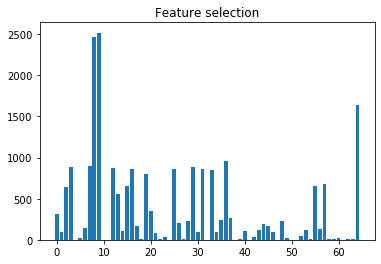

In [15]:
# Using amount of features based on PCA information
fs = SelectKBest(score_func=score_function, k=feature_tot)
fs.fit(input_train, target_train)
input_train_fs = fs.transform(input_train)
input_test_fs = fs.transform(input_test)

print(input_train_fs.shape)
plt.title("Feature selection")
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Hyperparameter tuning

In [16]:
#https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/


from sklearn.linear_model import Lasso,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve,validation_curve

N_FEATURES_COMPONENT = np.arange(2,10,2)

feature_select = [
        #PCA(iterated_power=N_FEATURES_COMPONENT), 
        #SelectKBest(f_regression),
        #ExtraTreesRegressor(random_state=seed, n_estimators=250),
        #RFE(RandomForestRegressor())
    ]


# GridSearchCV
estimators = [
    ('clf', SVR()),
]
param_grid = [
    {
        'clf':[SVR()],
        'clf__C':[0.1,10,100],
    },{
        'clf':[Lasso(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],

    },{
        'clf':[ElasticNet(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,5000,10000],
}]


pipeline = Pipeline(estimators)
grid = GridSearchCV(
    pipeline,
    cv=k, 
    param_grid=param_grid,
    return_train_score=True,
    refit=True,
    n_jobs=-1,
    scoring=scoring
) 
grid.fit(input_train_fs,target_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='scale', kernel='rbf',
                                            max_iter=-1, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'clf': [SVR(C=10, cache_size=200, coef0=0.0, degree=3,
                                      epsilon=0.1, gamma='scale', ke...
                         {'clf': [ElasticNet(alpha=1.0, copy_X=True,
                                             fit_intercept=True, l1_ratio=0.5,
                                             max_iter=1000, normalize=False,
                                       

## Get Model info

In [17]:
param_cols = ['']
score_cols = ['mean_train_score', 'std_test_score','mean_test_score', 'std_test_score']

grid_df = pd.DataFrame(grid.cv_results_, columns=score_cols)
grid_df.sort_values(by=['mean_test_score']).tail()
#print(grid_df)

print(f"Best score: {grid.best_score_}\nBest params {grid.best_params_}")

Best score: -78.86442223935714
Best params {'clf': SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'clf__C': 10}


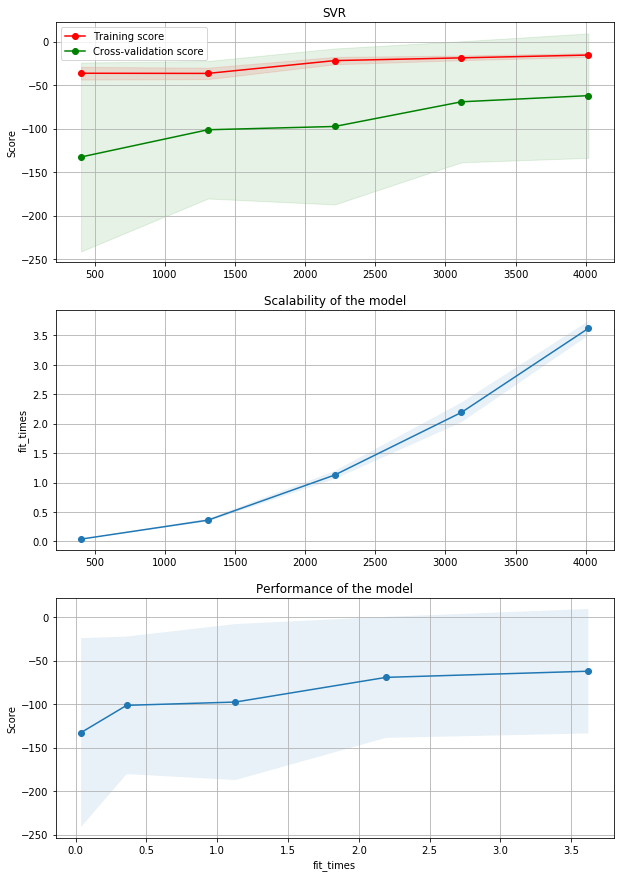

In [18]:
# Parameter to
param_range = np.arange(0.01, 50,5)
model = grid.best_params_['clf']
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plot_learning_curve(model, model.__class__.__name__, input_train, target_train, axes=axes[:], cv=k, scoring=scoring, n_jobs=-1)
plt.show()

# Predict testset

In [19]:
model = grid.best_params_['clf']
model.fit(input_train_fs, target_train)
model.predict(input_test_fs)

array([64.88659447, 64.94573034, 63.54742857, ..., 58.45371585,
       58.46915176, 56.52017334])